In [31]:
import numpy as np
import networkx as nx
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from numpy import linalg as LA
%matplotlib inline

### MODEL

In [17]:
class Model():
    def __init__(self, susc=1000, inf=3, rec=0, inf_prob=0.09, susc_prob=0.05):
        self.s = int(susc)
        self.i = int(inf)
        self.r = int(rec)
        self.threshold_inf = float(inf_prob)
        self.threshold_susc = float(susc_prob)

    def create_SIS_on_Network(self, G):
        S = self.s
        I = self.i

        N = S + I
        N = float(N)

        time_sis = 0

        threshold_inf = self.threshold_inf
        threshold_susc = self.threshold_susc

        sListSIS = []
        iListSIS = []

        while (S>0) and (I > 0) and (time_sis<5000):
            newI = 0
            for i in range(S-1):
                for j in nx.all_neighbors(G, i):
                    if random.random() < threshold_inf*(I/N):
                        newI += 1
            recoverI = 0
            for i in range(I):
                if random.random() < threshold_susc:
                    recoverI += 1
            S -= (newI - recoverI)
            I += (newI - recoverI)

            sListSIS.append(S)
            iListSIS.append(I)
            time_sis += 1

        #f = plt.figure()
        #plt.plot(iListSIS, 'b', label='Infectives')
        #plt.plot(sListSIS, 'g', label='Susceptibles')
        #plt.legend()
        #plt.xlabel('time')
        #plt.ylabel('population')
        #plt.title('SIS model on Erdos-Renyu network')
        #f.savefig('sis_network.png')

        return iListSIS, sListSIS

In [75]:
exSIS_Network = Model(susc=1000, inf=3, rec=0, inf_prob=0.00009, susc_prob=0.0005)
G = nx.erdos_renyi_graph(1000, 0.05)
inf, susc = exSIS_Network.create_SIS_on_Network(G)

Text(0.5,0,'time')

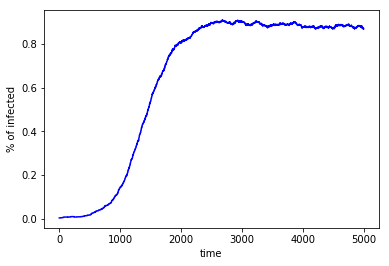

In [76]:
inf_frac = [x/1003.0 for x in inf]
plt.plot(inf_frac, 'b')
plt.ylabel("% of infected")
plt.xlabel("time")

In [95]:
def get_stability_time(inf_frac, num_steps, interval, eps, threshold):
    count = 0
    for i, j in zip(range(0, num_steps - interval, 1), range(interval, num_steps, 1)):
        if abs(inf_frac[j] - inf_frac[i]) < eps:
            count += 1
        else:
            count = 0
        if count > threshold:
            stab_time = i
            break
    return stab_time        

In [77]:
get_stability_time(inf_frac, 5000, 1000, 0.01, 20)

2353

### Ансамбль из 100 сетей

In [23]:
network_arr = np.arange(75)
N = 1000
p = 0.05
G_ensemble = []
for _ in network_arr:
    G_ensemble.append(nx.erdos_renyi_graph(N, p))

In [24]:
print(nx.number_of_edges(G_ensemble[0]), nx.number_of_edges(G_ensemble[1]))

24840 24772


### Зависимость доли зараженных от вероятности заражения

In [25]:
inf_array = []
for g in G_ensemble:
    exSIS_Network = Model(susc=1000, inf=3, rec=0, inf_prob=0.00009, susc_prob=0.0005)
    inf, susc = exSIS_Network.create_SIS_on_Network(g)
    inf_array.append(inf)

In [70]:
ens_inf = np.stack((inf_array), axis=-1)
avrg_inf = [np.mean(lst) for lst in ens_inf]
ens_inf

array([[  3,   3,   3, ...,   3,   3,   3],
       [  3,   3,   3, ...,   3,   3,   3],
       [  4,   3,   3, ...,   3,   3,   3],
       ...,
       [889, 888, 894, ..., 882, 883, 900],
       [889, 888, 894, ..., 882, 882, 900],
       [887, 888, 895, ..., 882, 882, 899]])

Text(0.5,1,'SIS model on Erdos-Renyu network (ensemble)')

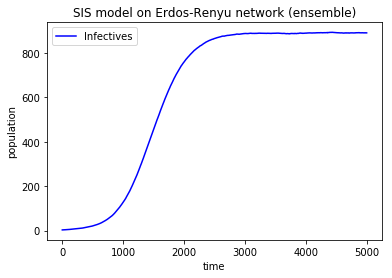

In [69]:
f = plt.figure()
plt.plot(avrg_inf, 'b', label='Infectives')
plt.legend()
plt.xlabel('time')
plt.ylabel('population')
plt.title('SIS model on Erdos-Renyu network (ensemble)')

In [100]:
get_stability_time(avrg_inf, 5000, 500, 0.1, 1)

3079

### Проверим гипотезу 1

Пусть мы имеем граф Эрдеша-Реньи с N вершинами и вероятностью связи p. Диаметр графа $d = N * p$. 
Верно ли, что $\alpha$ ~ $\frac{1}{d}$?

1.Создадим 10 графов с разным числом вершин (от 500 до 5000)

In [4]:
N_arr = np.arange(500, 5001, 500)
p = 0.05
G_arr = [nx.erdos_renyi_graph(N, p) for N in N_arr]

In [5]:
nx.number_of_nodes(G_arr[9])

5000

2.Посчитаем порог перколяции для каждого графа

In [4]:
def getInfectedFractionModel2(G, numberSteps, thresholdInf, startNode):    
    inf = []
    susc = []
    
    inf_dict = defaultdict(list)
    
    cur_infected_node = startNode
    
    for i in range(numberSteps):
        
        #заражаем здоровую вершину
        if cur_infected_node not in inf:
            inf.append(cur_infected_node)
        
        #выбираем всех неактивных соседей этой вершины
        not_infected_neighbors = []
        for j in list(nx.all_neighbors(G, cur_infected_node)):
            if j not in inf:
                not_infected_neighbors.append(j)
    
        #если у вершины нет здоровых соседей, завершаем заражение
        if not not_infected_neighbors:
            print("Exit")
            break
            
        if not_infected_neighbors:
            for elem in not_infected_neighbors:
                p = random.uniform(0, 1)
                if p < thresholdInf:
                    inf_dict[i].append(elem)
            
        #добавим в список зараженных новые вершины
        for j in inf_dict[i]:
            inf.append(j)
        
        if inf_dict[i]:
            inf.remove(cur_infected_node)
            cur_infected_node = random.choice(inf_dict[i])
            
    return inf

In [26]:
infection_array = []
prob_model2 = np.arange(0.00001, 0.1, 0.01)
for i in range(10):
    startNode = random.randint(1, nx.number_of_nodes(G_arr[i]))
    inf_arr_model2 = []
    for p in prob_model2:
        infected_arr = getInfectedFractionModel2(G_arr[i], 3000, p, startNode)
        inf_arr_model2.append(len(infected_arr) / nx.number_of_nodes(G_arr[i]))
    infection_array.append(inf_arr_model2)

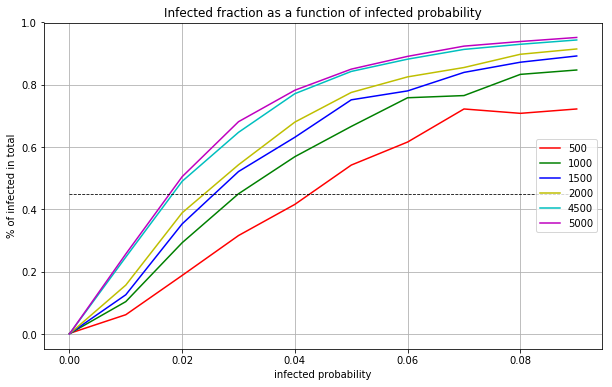

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(prob_model2, infection_array[0], 'r', linewidth=1.5, label='500')

ax.plot(prob_model2, infection_array[1], 'g', linewidth=1.5, label='1000')

ax.plot(prob_model2, infection_array[2], 'b', linewidth=1.5, label='1500')

ax.plot(prob_model2, infection_array[3], 'y', linewidth=1.5, label='2000')

ax.plot(prob_model2, infection_array[8], 'c', linewidth=1.5, label='4500')

ax.plot(prob_model2, infection_array[9], 'm', linewidth=1.5, label='5000')

ax.plot(prob_model2, np.full((len(prob_model2), 1), 0.45), 'k--', linewidth=0.8)

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Infected fraction as a function of infected probability')
ax.set_xlabel('infected probability')
ax.set_ylabel('% of infected in total')

plt.show()

### Проверим гипотезу о пороге перколяции и максимальном собственном значении матрицы

Построим матрицу A смежности графа и вектор s зараженных вершин. Рассмотрим максимальное собственное значение $\lambda_{1}$ матрицы $sA^{n}$. Верно ли, что порог перколяции $\alpha$ ~ $\frac{1}{\lambda_{1}}$ ?

In [7]:
N = 1000
p = 0.05
G = nx.erdos_renyi_graph(N, p)

In [9]:
A = nx.adjacency_matrix(G)

In [10]:
A = A.todense()
A

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [11]:
A.shape

(1000, 1000)

In [14]:
max(LA.eigvalsh(A))

50.79233479904683

In [158]:
startNode = random.randint(1, nx.number_of_nodes(G))
infected_arr = getInfectedFractionModel2(G, 1000, 0.5, startNode)
inf_frac = len(infected_arr) / N
inf_frac

0.847

In [159]:
s = list(np.full(N, 0))
for i in infected_arr:
    del s[i]
    s.insert(i, 1)

In [160]:
ss = np.dot(s, A)

In [199]:
A_ex = [[0, 1, 0, 0, 1],[1, 0, 0, 1, 0],[0, 0, 0, 0, 0],[0, 1, 0, 0, 1],[1, 0, 0, 1, 0]]
s_ex = [0, 1, 0, 0, 0]
s2 = np.dot(s_ex, A_ex)
s3 = np.dot(s2, A_ex)
print(s3)

[0 2 0 0 2]


In [200]:
np.dot(s_ex, lg.matrix_power(A_ex, 2))

array([0, 2, 0, 0, 2])